In [3]:
#import stats packages
import pandas as pd
import statsmodels.api as sm
from numpy import random
import numpy as np

#import plot packages
import plotly.express as plt
import geopandas as gpd
import plotly.graph_objects as go
import matplotlib.pyplot as mp
from shapely.geometry import Point

In [4]:
#opening files
cities = pd.read_csv('pset3_cities.csv')
distances = pd.read_csv('pset3_distances.csv')
stations = pd.read_csv('pset3_stations.csv')
lines = pd.read_csv('pset3_lines.csv')

In [5]:
#creating deltalines

stations = stations.merge(lines, how = 'left')
stations['year_opening'] = stations['year_opening'].replace([2017, 2018, 2019], [None, None, None])
stations = stations.dropna()


stationsdum = pd.get_dummies(stations['cityid'])

cities['numstat'] = cities['cityid']
cities['numlinks'] = cities['cityid']
cities['avgspd'] = cities['cityid']
a = []

for i in cities['cityid']:

    if i in stationsdum.columns:
        cities['numstat'] = cities['numstat'].replace(i, stationsdum[i].sum())

    else:
        cities['numstat'] = cities['numstat'].replace(i, 0)


In [6]:
#creating log distance to nearest station

cities['logdist'] = cities['cityid']
for i in list(set(list(cities['cityid']))):

    trunc = distances[distances['cityid1']==i]
    if cities[cities['cityid']==i]['numstat'].mean() > 0:
        cities['logdist'] = cities['logdist'].replace(i, trunc[trunc['cityid2']==i]['dist'].min())
    else:
        citiestr = cities[cities['numstat'] > 0]
        df = pd.DataFrame(columns = ['cityid1', 'cityid2', 'dist'])
        for a in list(set(list(citiestr['cityid']))):
            df = df.append(trunc[trunc['cityid2'] == a])
        cities['logdist'] = cities['logdist'].replace(i, df['dist'].min())


In [10]:
#re-initiating stations
stations = pd.read_csv('pset3_stations.csv')

In [11]:
#converting to logs
cities['logdist'] = np.log(cities['logdist'])

In [12]:
#A no FE no constant

citiesempt = cities.dropna(subset = ['empgrowth'])

treat = ['logdist']

vals = sm.OLS(citiesempt['empgrowth'], citiesempt[treat])
out = vals.fit(cov_type = 'HC0')
print(out.summary())

                                 OLS Regression Results                                
Dep. Variable:              empgrowth   R-squared (uncentered):                   0.460
Model:                            OLS   Adj. R-squared (uncentered):              0.458
Method:                 Least Squares   F-statistic:                              211.8
Date:                Sat, 18 Nov 2023   Prob (F-statistic):                    6.12e-36
Time:                        20:12:06   Log-Likelihood:                         -31.535
No. Observations:                 275   AIC:                                      65.07
Df Residuals:                     274   BIC:                                      68.69
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [13]:
#A no FE with constant

citiesempt = cities.dropna(subset = ['empgrowth'])

treat = ['logdist']

vals = sm.OLS(citiesempt['empgrowth'], sm.add_constant(citiesempt[treat]))
out = vals.fit(cov_type = 'HC0')
print(out.summary())

FEs = out.predict(sm.add_constant(citiesempt[treat]))

                            OLS Regression Results                            
Dep. Variable:              empgrowth   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     23.45
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           2.15e-06
Time:                        20:12:16   Log-Likelihood:                 2.1976
No. Observations:                 275   AIC:                           -0.3952
Df Residuals:                     273   BIC:                             6.838
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8526      0.119      7.158      0.0

In [14]:
#A with FE
regions = pd.get_dummies(cities['province_en'])
cities = pd.concat([cities, regions], axis = 1)

citiesempt = cities.dropna(subset = ['empgrowth'])

treat = ['logdist']
dummies = list(set(list(citiesempt['province_en'])))

vals = sm.OLS(citiesempt['empgrowth'], citiesempt[treat+dummies])
out = vals.fit(cov_type = 'HC0')
print(out.summary())

FEs = out.predict(citiesempt[treat+dummies])

                            OLS Regression Results                            
Dep. Variable:              empgrowth   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 18 Nov 2023   Prob (F-statistic):                nan
Time:                        20:12:17   Log-Likelihood:                 69.538
No. Observations:                 275   AIC:                            -77.08
Df Residuals:                     244   BIC:                             35.04
Df Model:                          30                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
logdist           -0.0812      0.023     -3.

In [30]:
lines['draws1'] =  0


for h in range(999):
    adds = []
    for i in range(19):
        short = lines[lines['nlinks'] == i]
        xtrashort = len(short[short['year_opening']<=2016])
        new = list(set(list(short.index)))
        new2 = list(random.permutation(new)[:xtrashort])
        adds= adds + new2
    sl = adds
    
    lines_temp = lines.iloc[sl]
    stations_temp = stations.merge(lines_temp)
    stationsdum = pd.get_dummies(stations_temp['cityid'])

    

    cities['numstattemp'] = cities['cityid']
    for i in cities['cityid']:
        if i in stationsdum.columns:
            cities['numstattemp'] = cities['numstattemp'].replace(i, stationsdum[i].sum())

        else:
            cities['numstattemp'] = cities['numstattemp'].replace(i, 0)
            
    citiestr = cities[cities['numstattemp'] > 0]
    cities['logdist'] = cities['cityid']
    for i in list(set(list(cities['cityid']))):

        trunc = distances[distances['cityid1']==i]
        if cities[cities['cityid']==i]['numstattemp'].mean() > 0:
            cities['logdist'] = cities['logdist'].replace(i, trunc[trunc['cityid2']==i]['dist'].min())
        else:
            df = pd.DataFrame(columns = ['cityid1', 'cityid2', 'dist'])
            for x in list(set(list(citiestr['cityid']))):
                df = df.append(trunc[trunc['cityid2'] == x])
            cities['logdist'] = cities['logdist'].replace(i, df['dist'].min())
            
    if h == 0:
        cities['logdistfinal1'] = cities['logdist']
        cities['logdistl'] = cities['logdist']
    else:
        cities['logdistfinal1'] = cities['logdistfinal1'] +cities['logdist']


    print(h)
cities['logdistfinal1'] = cities['logdistfinal1']/(h+1)
cities.head(30)

#i dont wanna talk about how ugly this code is. i'm sorry. i'm just sorry.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,Unnamed: 0,cityid,city_en,city_cn,province_en,province_cn,latitude,longitude,empgrowth,dist_beijing,...,shandong.1,shanghai.1,shanxi.1,sichuan.1,tianjin.1,tibet.1,xinjiang.1,yunnan.1,zhejiang.1,demeaned
0,0,1,karamay,克拉玛依,xinjiang,新疆,45.461518,85.199446,0.119534,2602.69970,...,0,0,0,0,0,0,1,0,0,-452.711020
1,1,2,changji,昌吉,xinjiang,新疆,44.313793,88.087258,NaN,2370.31810,...,0,0,0,0,0,0,1,0,0,-423.470774
2,2,3,shihezi,石河子,xinjiang,新疆,44.293198,86.033775,NaN,2533.64090,...,0,0,0,0,0,0,1,0,0,-462.890200
3,3,4,xilingol,锡林郭勒盟,inner mongolia,内蒙古,43.945251,116.069210,NaN,446.99963,...,0,0,0,0,0,0,0,0,0,77.639605
4,4,5,benxi,本溪,liaoning,辽宁,41.290112,123.763660,-0.034191,642.08984,...,0,0,0,0,0,0,0,0,0,-6.796225
5,5,6,jiayuguan,嘉峪关,gansu,甘肃,39.802452,98.272919,0.316997,1541.75740,...,0,0,0,0,0,0,0,0,0,-246.254128
6,6,7,laiwu,莱芜,shandong,山东,36.205116,117.661730,0.174354,429.53101,...,1,0,0,0,0,0,0,0,0,-13.207115
7,7,8,shennongjia,神农架,hubei,湖北,31.754316,110.676950,NaN,1043.39120,...,0,0,0,0,0,0,0,0,0,62.728957
8,8,9,tianmen,天门,hubei,湖北,30.656250,113.164120,NaN,1071.33950,...,0,0,0,0,0,0,0,0,0,-21.954966
9,9,10,ezhou,鄂州,hubei,湖北,30.322286,114.726000,NaN,1078.81180,...,0,0,0,0,0,0,0,0,0,-2.689504


In [31]:
np.log(cities['logdistfinal1']).describe()

count    340.000000
mean       4.487112
std        0.790581
min        2.832481
25%        3.996449
50%        4.295818
75%        4.769178
max        7.338823
Name: logdistfinal1, dtype: float64

In [32]:
cities.to_csv('interpset3.csv')

In [33]:
stations = pd.read_csv('pset3_stations.csv')

stations = stations.merge(lines, how = 'left')
stations['year_opening'] = stations['year_opening'].replace([2017, 2018, 2019], [None, None, None])
stations = stations.dropna()


stationsdum = pd.get_dummies(stations['cityid'])

cities['numstat'] = cities['cityid']
cities['numlinks'] = cities['cityid']
cities['avgspd'] = cities['cityid']
a = []

for i in cities['cityid']:

    if i in stationsdum.columns:
        cities['numstat'] = cities['numstat'].replace(i, stationsdum[i].sum())

    else:
        cities['numstat'] = cities['numstat'].replace(i, 0)


cities['logdist'] = cities['cityid']
for i in list(set(list(cities['cityid']))):

    trunc = distances[distances['cityid1']==i]
    if cities[cities['cityid']==i]['numstat'].mean() > 0:
        cities['logdist'] = cities['logdist'].replace(i, trunc[trunc['cityid2']==i]['dist'].min())
    else:
        citiestr = cities[cities['numstat'] > 0]
        df = pd.DataFrame(columns = ['cityid1', 'cityid2', 'dist'])
        for a in list(set(list(citiestr['cityid']))):
            df = df.append(trunc[trunc['cityid2'] == a])
        cities['logdist'] = cities['logdist'].replace(i, df['dist'].min())


In [54]:
cities.to_csv('final2_pset3.csv')

In [55]:
cities = pd.read_csv('final2_pset3.csv')

In [56]:
cities['logdistf'].describe()

count    340.000000
mean       4.487112
std        0.790581
min        2.832481
25%        3.996449
50%        4.295818
75%        4.769178
max        7.338823
Name: logdistf, dtype: float64

In [64]:
cities['loglogdist'] = np.log(cities['logdist'])

In [58]:
cities['logdistf'] = np.log(cities['logdistfinal1'])

In [65]:
#reading in csv so i dont have to rerun this crazy long simulation

#no FE with constant

citiesempt = cities.dropna(subset = ['empgrowth'])

treat = ['loglogdist', 'logdistf']

vals = sm.OLS(citiesempt['empgrowth'], sm.add_constant(citiesempt[treat]))
out = vals.fit(cov_type = 'HC0')
print(out.summary())


                            OLS Regression Results                            
Dep. Variable:              empgrowth   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     11.64
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           1.42e-05
Time:                        21:20:37   Log-Likelihood:                 2.9031
No. Observations:                 275   AIC:                            0.1938
Df Residuals:                     272   BIC:                             11.04
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9278      0.141      6.585      0.0

In [66]:
#no FE with constant

citiesempt = cities.dropna(subset = ['empgrowth'])

treat = citiesempt['loglogdist'] - citiesempt['logdistf']

vals = sm.OLS(citiesempt['empgrowth'], sm.add_constant(treat))
out = vals.fit(cov_type = 'HC0')
print(out.summary())


                            OLS Regression Results                            
Dep. Variable:              empgrowth   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     4.863
Date:                Sun, 19 Nov 2023   Prob (F-statistic):             0.0283
Time:                        21:20:42   Log-Likelihood:                -12.877
No. Observations:                 275   AIC:                             29.75
Df Residuals:                     273   BIC:                             36.99
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2624      0.016     16.605      0.0

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-51-aba84b46b721>:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  shapefile2 = gpd.sjoin(gdf1, shapefile, how="right", op='inte

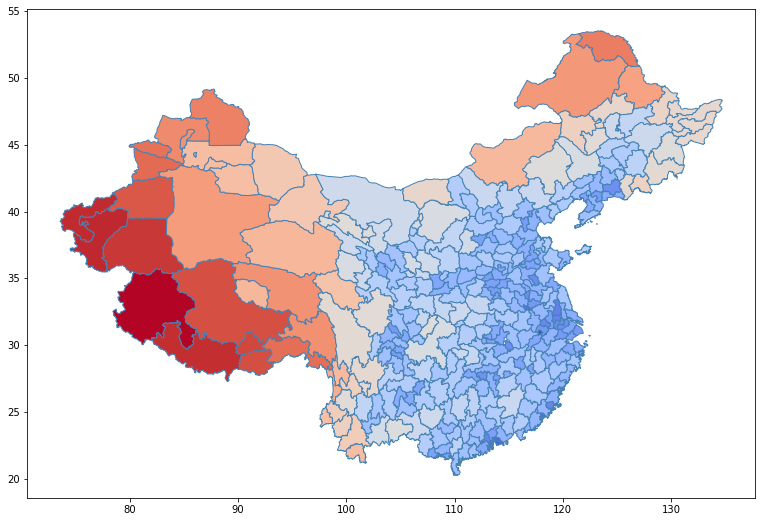

In [51]:
#maps!

shapefile = gpd.read_file("chn_admbnda_adm2_ocha.shp")

crs = {'init': shapefile.crs}
geometry = [Point(xy) for xy in zip(cities['longitude'], cities['latitude'])]
gdf1 = gpd.GeoDataFrame(cities, crs=crs, geometry=geometry)

shapefile2 = gpd.sjoin(gdf1, shapefile, how="right", op='intersects')

base = shapefile2.plot(figsize=(15,9), column = 'logdistf', edgecolor='steelblue', cmap = 'coolwarm')



/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-52-03edc0c08ced>:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  shapefile2 = gpd.sjoin(gdf1, shapefile, how="right", op='int

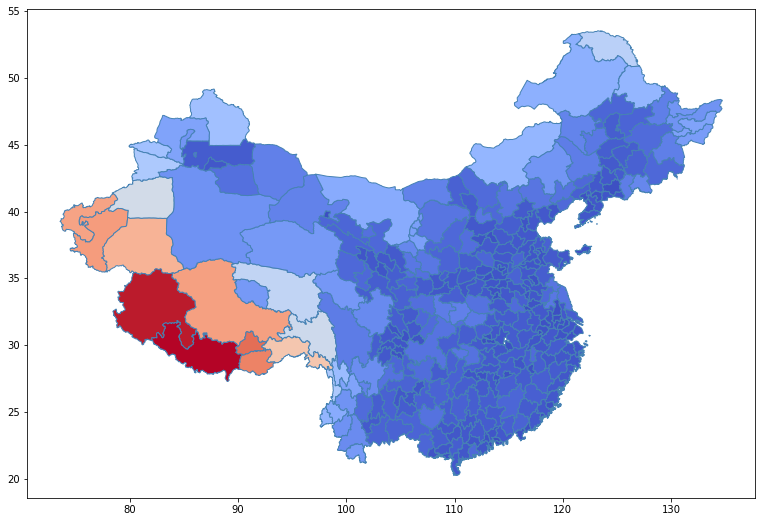

In [52]:
#maps!

shapefile = gpd.read_file("chn_admbnda_adm2_ocha.shp")

cities['demeaned'] = cities['logdist'] - cities['logdistf']

crs = {'init': shapefile.crs}
geometry = [Point(xy) for xy in zip(cities['longitude'], cities['latitude'])]
gdf1 = gpd.GeoDataFrame(cities, crs=crs, geometry=geometry)

shapefile2 = gpd.sjoin(gdf1, shapefile, how="right", op='intersects')

base = shapefile2.plot(figsize=(15,9), column = 'demeaned', edgecolor='steelblue', cmap = 'coolwarm')

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-53-5232853c41c3>:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  shapefile2 = gpd.sjoin(gdf1, shapefile, how="right", op='int

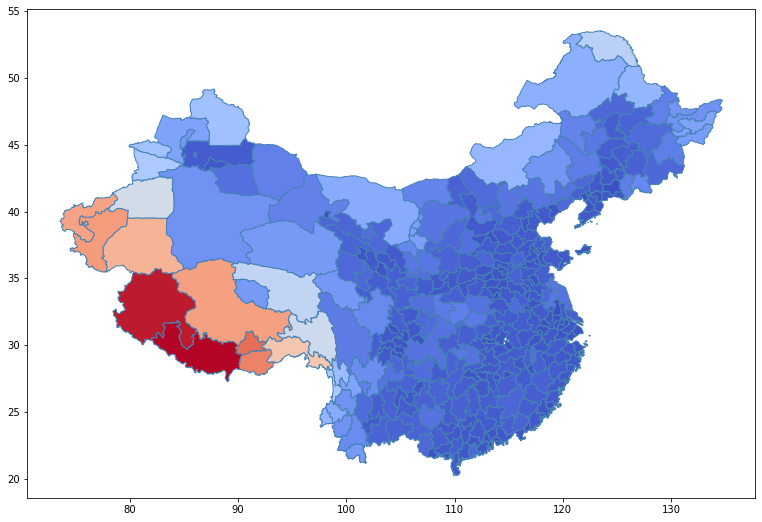

In [53]:
#maps!

shapefile = gpd.read_file("chn_admbnda_adm2_ocha.shp")


crs = {'init': shapefile.crs}
geometry = [Point(xy) for xy in zip(cities['longitude'], cities['latitude'])]
gdf1 = gpd.GeoDataFrame(cities, crs=crs, geometry=geometry)

shapefile2 = gpd.sjoin(gdf1, shapefile, how="right", op='intersects')

base = shapefile2.plot(figsize=(15,9), column = 'logdist', edgecolor='steelblue', cmap = 'coolwarm')
